In [9]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# append sys.path
import sys
sys.path.append('../src')

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from simulator.DM_model import DM_model
from parse_data.decode_parameter import decode_mat_fitted_parameters
from parse_data.parse_trial_data import parse_trial_data, compute_subject_acc, correctness_of_array
import os
import numpy as np

In [14]:
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True

# remove all edges
# mpl.rcParams["axes.edgecolor"] = "none"

font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)

## generate input seqC

In [15]:
from data_generator.input_c import seqCGenerator
seqC = seqCGenerator().generate(
    MS_list=[0.2, 0.4, 0.8], 
    dur_max=14,
    sample_size=700*100,
    add_zero=True)
seqC.shape

(1470000, 15)

In [16]:
# check if seqC contains nan
np.isnan(seqC).any()

True

## sampling from the prior BoxUniform

In [17]:
from sbi import utils as utils
import torch

# model B-G-L0S-O-N-
prior_min = [-3.7, -36, 0, -34, 5]
prior_max = [2.5, 71, 0, 18, 7]
num_sample = int(10**(len(prior_min)-1))
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

theta = prior.sample((num_sample,))
theta.shape

torch.Size([10000, 5])

Text(0, 0.5, 'count')

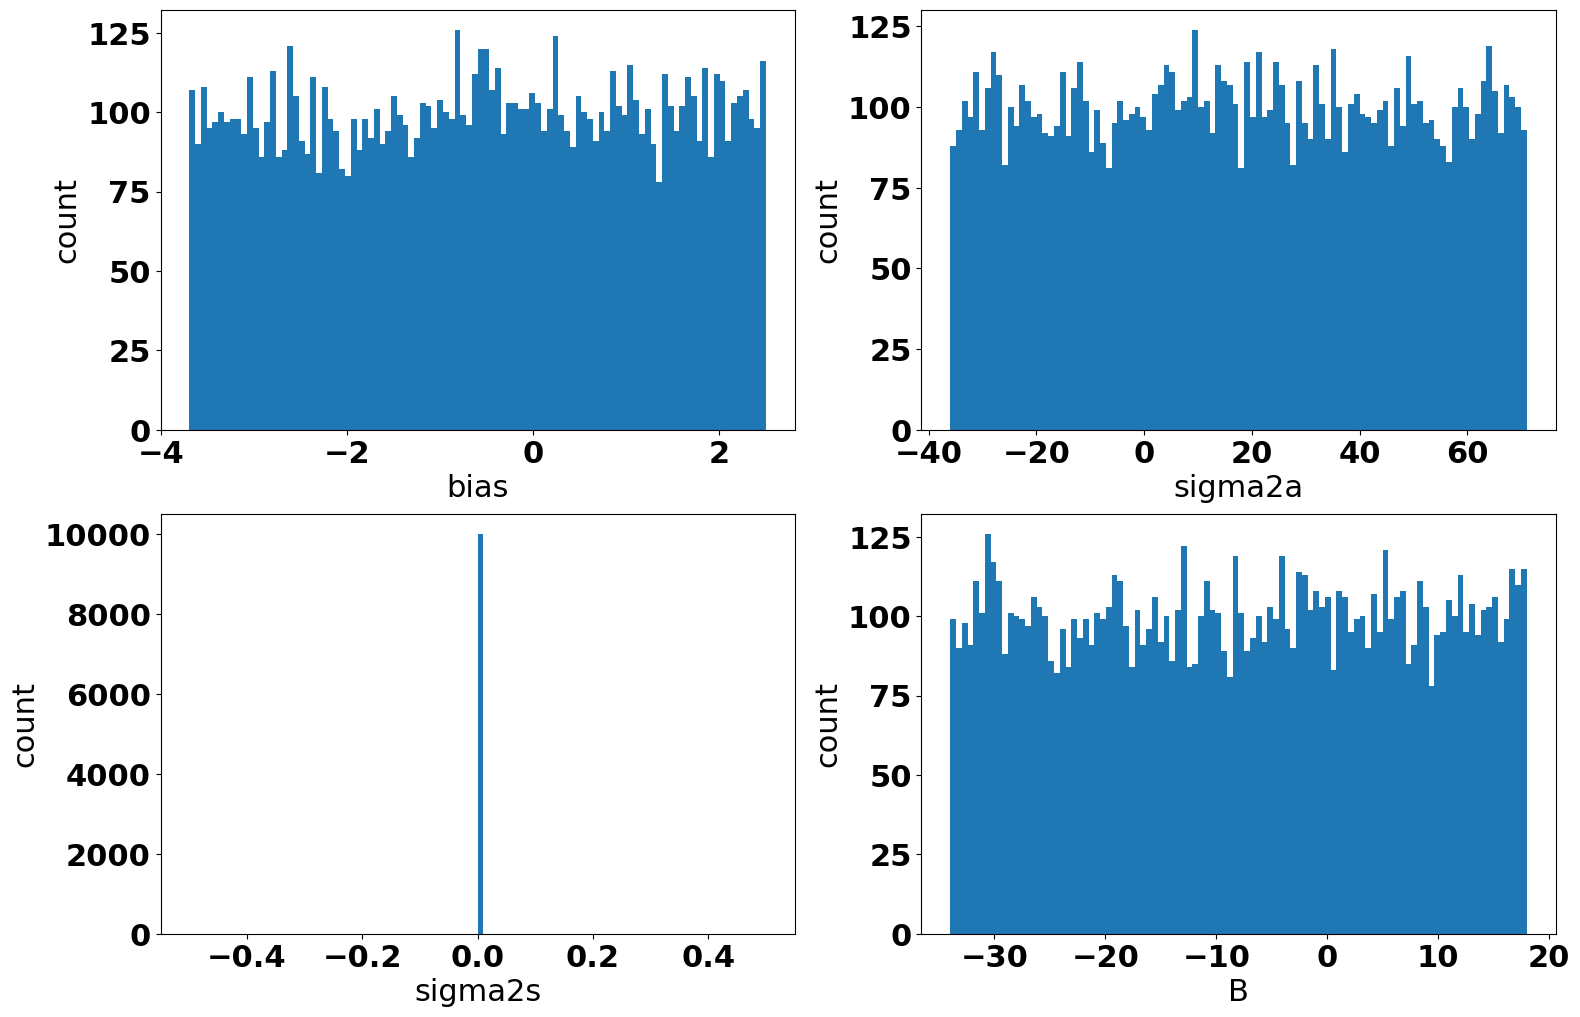

In [18]:
fig = plt.figure(figsize=(18, 12))
gs = mpl.gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
ax.hist(theta[:,0], bins=100)
ax.set_xlabel('bias')
ax.set_ylabel('count')

ax = fig.add_subplot(gs[0, 1])
ax.hist(theta[:,1], bins=100)
ax.set_xlabel('sigma2a')
ax.set_ylabel('count')

ax = fig.add_subplot(gs[1, 0])
ax.hist(theta[:,2], bins=100)
ax.set_xlabel('sigma2s')
ax.set_ylabel('count')

ax = fig.add_subplot(gs[1, 1])
ax.hist(theta[:,3], bins=100)
ax.set_xlabel('B')
ax.set_ylabel('count')

## generate dataset for training 

In [19]:
# numpy print precision 2
np.set_printoptions(precision=2)

In [20]:
from data_generator.dataset_for_training import seq_norm_repeat, simulate

seqC1 = seqC[0,:]
params = [-0.2, 1, 0, -12, 1.1]
modelName = 'B-G-L0S-O-N-'
num_LR_sample = 100

# model = DM_model(params=params, modelName=modelName)
# _, probR = model.simulate(np.array(seqC1))

# x_ = seq_norm_repeat(seqC1, nan2num=-2, n_repeat=num_LR_sample)
# cDist = np.random.choice([0,1], p=[1-probR, probR], size=100) # 0: left, 1: right
# x = np.hstack([x_, cDist.reshape(-1, 1)])

In [21]:
nan2num = -2
x_, theta_ = simulate((seqC1, params, modelName, num_LR_sample, nan2num))
x_.shape, theta_.shape

[ 0.  -0.2  0.2  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan] [-0.2, 1, 0, -12, 1.1]
probR: 0.6017567997310335


(torch.Size([100, 16]), torch.Size([100, 5]))

In [26]:
seqC = [0,0,0,np.nan ,np.nan ,np.nan ,np.nan ,np.nan ,np.nan ,np.nan ,np.nan ,np.nan ,np.nan ,np.nan ,np.nan ]
params = [-1.8762262, -9.188831, 0.0, 2.3199158, 5.120748]
simulate((seqC1, params, modelName, num_LR_sample, nan2num))


[ 0.  -0.2  0.2  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan] [-1.8762262, -9.188831, 0.0, 2.3199158, 5.120748]
probR: 1.0


(tensor([[0.6667, 0.6000, 0.7333,  ..., 0.0000, 0.0000, 1.0000],
         [0.6667, 0.6000, 0.7333,  ..., 0.0000, 0.0000, 1.0000],
         [0.6667, 0.6000, 0.7333,  ..., 0.0000, 0.0000, 1.0000],
         ...,
         [0.6667, 0.6000, 0.7333,  ..., 0.0000, 0.0000, 1.0000],
         [0.6667, 0.6000, 0.7333,  ..., 0.0000, 0.0000, 1.0000],
         [0.6667, 0.6000, 0.7333,  ..., 0.0000, 0.0000, 1.0000]],
        dtype=torch.float64),
 tensor([[-1.8762, -9.1888,  0.0000,  2.3199,  5.1207],
         [-1.8762, -9.1888,  0.0000,  2.3199,  5.1207],
         [-1.8762, -9.1888,  0.0000,  2.3199,  5.1207],
         [-1.8762, -9.1888,  0.0000,  2.3199,  5.1207],
         [-1.8762, -9.1888,  0.0000,  2.3199,  5.1207],
         [-1.8762, -9.1888,  0.0000,  2.3199,  5.1207],
         [-1.8762, -9.1888,  0.0000,  2.3199,  5.1207],
         [-1.8762, -9.1888,  0.0000,  2.3199,  5.1207],
         [-1.8762, -9.1888,  0.0000,  2.3199,  5.1207],
         [-1.8762, -9.1888,  0.0000,  2.3199,  5.1207],
     

In [61]:
arr = np.array(
    [[0,0,0],
     [0,1,1],
     [0,1,0],
     [0,0,0],]
)
MS = 0.1
zero_rows = np.where(~arr.any(axis=1))[0]
arr = np.delete(arr, zero_rows, axis=0)
new = MS * np.random.choice([-1,0,1], size=(len(zero_rows), 3), p=[0.35, 0.3, 0.35])
arr = np.vstack([arr, new])
arr

array([[ 0. ,  1. ,  1. ],
       [ 0. ,  1. ,  0. ],
       [ 0.1,  0. , -0.1],
       [-0.1,  0.1,  0. ]])

In [62]:
len(zero_rows)

2

In [73]:
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
c = torch.empty((0,3))
d = torch.vstack([c,b])
torch.vstack([d, a])

tensor([[4., 5., 6.],
        [1., 2., 3.]])